## Install Requirements
******Remember to restart the kernel after installing

In [2]:
%pip install --upgrade pip
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.
Ignoring tensorflow: markers 'sys_platform == "linux"' don't match your environment
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os, sys, shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

## Process the videos into frames

In [80]:
def extractImages(pathIn, pathOut, leakRange, nonleakRange):

  '''
  Input:
    String: pathIn should be the path of the video 
    String: pathOut should be the path of the folder where the name of the folder is the name of the video
    Tuple: range of leak frames from video
    Tuple: range of nonleak frames from video

  Output:
    creates two subfolders in pathOut called Leaks and Nonleaks
      Leaks folder contains the frames where there are leaks
      Nonleaks folder contains the frames where there are noleaks
  '''

  leakPath = os.path.join(pathOut, "Leak")
  nonleakPath = os.path.join(pathOut, "Nonleaks")
  
  os.makedirs(leakPath, exist_ok=True)
  os.makedirs(nonleakPath, exist_ok=True)

  def helper(pathIn, pathOut, range, isleak):
    '''
    Might need to clean this up, but this was extracted from the original extractImages from the previous implementation
    
    '''
    count = range[0]
    start = 0
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    success = True
    X_design = []
    if vidcap.isOpened():
      while success and count < range[1]:
          vidcap.set(cv2.CAP_PROP_POS_MSEC, (start*1000))    # added this line 
          success, image = vidcap.read()
          if success:
            print ('Read a new frame: ', count, " ,isleak: ", isleak)
            label = 0
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY ) # convert to grayscale
            flattened = image.flatten()
            if isleak:
              cv2.imwrite(os.path.join(pathOut, "leak.frame%d.jpg" % count), image)     # save frame as JPEG file
              label = 1
            else:
              cv2.imwrite(os.path.join(pathOut, "nonleak.frame%d.jpg" % count), image)
            X_design.append(flattened)
            count += 1
            start += 1
          else:
            break
      vidcap.release()
    cv2.destroyAllWindows()
    return np.vstack(X_design)
  # call helper for both leak and nonleak
  X_leak = helper(pathIn, leakPath, leakRange, True)
  y_leak = np.ones(X_leak.shape[0])
  X_nonleak = helper(pathIn, nonleakPath, nonleakRange, False)
  y_nonleak = np.zeros(X_nonleak.shape[0])

  X = np.vstack((X_leak, X_nonleak))
  y = np.concatenate((y_leak, y_nonleak), axis=0)
  
  return X, y

### Get the images now

In [81]:
# get generic path to directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

# get all raw video data directories
data_dir = os.path.join(dir_path, 'data')

train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

frame_data_dir = os.path.join(dir_path, 'frame_data')
frame_train_data_dir = os.path.join(frame_data_dir, 'train')
frame_test_data_dir = os.path.join(frame_data_dir, 'test')

In [82]:
raw_data = np.loadtxt(os.path.join(dir_path, 'leak_range.csv'), skiprows=1, delimiter=',', dtype=int)

nonleak_range = dict(zip(raw_data[:, 0], raw_data[:, 1:3]))

In [83]:
image_dim = (240, 320)
X_train, y_train = np.array([], dtype=np.int64).reshape(0, image_dim[1]), []
vid_count = 1
cur_count = 1

for file in os.listdir(train_data_dir):
    if cur_count > vid_count:
        break
    vid_path = os.path.join(train_data_dir, file)
    vid_id = int(os.path.basename(vid_path)[4:8])

    nonleak_start = 1
    nonleak_end = nonleak_range[vid_id][0]
    leak_start = nonleak_end + 1
    leak_end = nonleak_range[vid_id][1]

    X_vid, y_vid = extractImages(vid_path, frame_train_data_dir, (leak_start, leak_end), (nonleak_start, nonleak_end))
    X_train = np.concatenate((X_train, X_vid), axis=0)
    y_train.append(y_vid)
    print('done', cur_count)
    cur_count += 1

y_train = np.array(y_train) # improve time complexity

X_train, y_train

Read a new frame:  211  ,isleak:  True
(240, 320)
Read a new frame:  212  ,isleak:  True
(240, 320)
Read a new frame:  213  ,isleak:  True
(240, 320)
Read a new frame:  214  ,isleak:  True
(240, 320)
Read a new frame:  215  ,isleak:  True
(240, 320)
Read a new frame:  216  ,isleak:  True
(240, 320)
Read a new frame:  217  ,isleak:  True
(240, 320)
Read a new frame:  218  ,isleak:  True
(240, 320)
Read a new frame:  219  ,isleak:  True
(240, 320)
Read a new frame:  220  ,isleak:  True
(240, 320)
Read a new frame:  221  ,isleak:  True
(240, 320)
Read a new frame:  222  ,isleak:  True
(240, 320)
Read a new frame:  223  ,isleak:  True
(240, 320)
Read a new frame:  224  ,isleak:  True
(240, 320)
Read a new frame:  225  ,isleak:  True
(240, 320)
Read a new frame:  226  ,isleak:  True
(240, 320)
Read a new frame:  227  ,isleak:  True
(240, 320)
Read a new frame:  228  ,isleak:  True
(240, 320)
Read a new frame:  229  ,isleak:  True
(240, 320)
Read a new frame:  230  ,isleak:  True
(240, 320)


(array([[ 93,  93,  93, ...,   1,   1,   1],
        [ 94,  94,  93, ...,   1,   1,   1],
        [ 94,  93,  90, ...,   1,   1,   1],
        ...,
        [196, 187, 178, ..., 152, 153, 153],
        [153, 146, 140, ..., 151, 151, 152],
        [138, 133, 132, ..., 150, 151, 151]]),
 array([[1., 1., 1., ..., 0., 0., 0.]]))

## WARNING: everything below here is currently untested (TODO)

In [42]:
# get generic path to directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

original_dataset_dir = os.path.join(dir_path, 'train')
base_dir = os.path.join(dir_path, 'NewTrain')

shutil.rmtree(base_dir, ignore_errors=True)
os.mkdir(base_dir) 
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir) 
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir) 
test_dir = os.path.join(base_dir, 'test') 
os.mkdir(test_dir) 

train_leaks_dir = os.path.join(train_dir, 'leaks')
os.mkdir(train_leaks_dir) 

train_nonleaks_dir = os.path.join(train_dir, 'nonleaks') 
os.mkdir(train_nonleaks_dir) 


validation_leaks_dir = os.path.join(validation_dir, 'leaks') 
os.mkdir(validation_leaks_dir) 
validation_nonleaks_dir = os.path.join(validation_dir, 'nonleaks') 
os.mkdir(validation_nonleaks_dir) 

test_leaks_dir = os.path.join(test_dir, 'leaks') 
os.mkdir(test_leaks_dir) 
test_nonleaks_dir = os.path.join(test_dir, 'nonleaks') 
os.mkdir(test_nonleaks_dir) 

In [9]:
fnames = ['leak.frame{}.jpg'.format(i) for i in range(1476, 1487)] 
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname) 
    dst = os.path.join(train_cats_dir, fname) 
    shutil.copyfile(src, dst) 

fnames = ['leak.frame{}.jpg'.format(i) for i in range(1489, 1491)] 
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname) 
    dst = os.path.join(validation_cats_dir, fname) 
    shutil.copyfile(src, dst) 

fnames = ['leak.frame{}.jpg'.format(i) for i in range(1491, 1494)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname) 
    shutil.copyfile(src, dst) 


fnames = ['nonleak.frame{}.jpg'.format(i) for i in range(1, 10)] 
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname) 
    dst = os.path.join(train_dogs_dir, fname) 
    shutil.copyfile(src, dst) 

fnames = ['nonleak.frame{}.jpg'.format(i) for i in range(10, 14)] 
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname) 
    dst = os.path.join(validation_dogs_dir, fname) 
    shutil.copyfile(src, dst) 

fnames = ['nonleak.frame{}.jpg'.format(i) for i in range(14, 18)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname) 
    shutil.copyfile(src, dst) 

NameError: name 'train_cats_dir' is not defined

In [10]:
from keras import layers 
from keras import models 

model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten()) 
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [11]:
from keras import optimizers 

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

### Background Subtraction
Will be using opencv's MOG2 background subtraction method as it is one of the recommended methods from Wang 2020.
1. Background Subtraction through MOG2
2. Erosion to clean up noise

Credits to this [CV guide](https://github.com/jrobchin/Computer-Vision-Basics-with-Python-Keras-and-OpenCV/blob/master/notebook.ipynb) for the implementation reference



In [ ]:
import cv2 as cv

backSub = cv.createBackgroundSubtractorMOG2()

# input image frame is 3D tensor
def backsub_per_frame(frame):
    fgmask = backSub.apply(frame)
    cv.imshow('fgmask', fgmask)
#     print(fgmask.dtype, frame.dtype)
#     fgmask = cv.erode(fgmask, np.ones((3,3), dtype=np.uint8), iterations=1)
    return np.array(fgmask, dtype='float32')

    

In [ ]:
# debugging

def print_image(frame):
    plt.imshow((frame*255).astype(np.uint8))
    return frame

In [78]:
X_train.shape

(354240, 320)

In [79]:
X_train[0]

array([93, 93, 93, 95, 96, 93, 87, 82, 77, 68, 58, 52, 48, 45, 38, 32, 23,
       18, 12,  8,  5,  4,  1,  0,  0,  2,  2,  0,  0,  1,  3,  2,  3,  8,
       13, 20, 26, 31, 33, 34, 28, 26, 25, 30, 39, 48, 55, 58, 65, 65, 66,
       66, 66, 63, 62, 61, 52, 49, 44, 40, 39, 39, 41, 44, 53, 58, 65, 69,
       70, 73, 75, 77, 83, 82, 82, 81, 81, 80, 80, 80, 80, 79, 76, 73, 69,
       66, 63, 62, 69, 68, 67, 66, 66, 68, 69, 72, 74, 75, 75, 75, 74, 72,
       70, 68, 68, 68, 68, 70, 73, 77, 81, 84, 86, 84, 82, 81, 81, 82, 83,
       84, 87, 86, 86, 84, 83, 82, 82, 81, 82, 82, 81, 79, 77, 75, 74, 74,
       79, 79, 79, 79, 79, 77, 77, 77, 84, 84, 83, 82, 82, 81, 80, 80, 74,
       73, 72, 72, 72, 74, 76, 77, 82, 82, 82, 82, 82, 82, 81, 81, 81, 83,
       86, 89, 91, 91, 91, 90, 90, 87, 81, 77, 77, 80, 84, 88, 89, 89, 88,
       88, 87, 86, 86, 84, 89, 88, 87, 86, 83, 82, 81, 81, 80, 81, 84, 88,
       90, 90, 91, 90, 86, 84, 83, 83, 83, 86, 89, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 89, 90

In [19]:
val_split = 0.25
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=val_split, stratify=y_train)

X = np.concatenate((X_t, X_v))
y = np.concatenate((y_t, y_v))

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# for now, dont do augmentation
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1. / 255,
    validation_split=0.25,
#     horizontal_flip=True,
#     shear_range=0.2,
#     zoom_range=0.05,
)
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
) 

train_flow = train_datagen.flow(
    X_train, y_train, 
    # target_size=(150, 150), 
    batch_size=32,
    # class_mode='binary',
    subset='training'
)

val_flow = train_datagen.flow(
    X_train, y_train, 
    # target_size=(150, 150), 
    batch_size=8,
    # class_mode='binary',
    subset='validation'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary'
)
print(train_generator)

ValueError: Training and validation subsets have different number of classes after the split. If your numpy arrays are sorted by the label, you might want to shuffle them.

In [ ]:
generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=40,
    class_mode='binary' 
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=40, 
    class_mode='binary'
)
print(train_generator)

Epoch 1/100
1/1 [==============================] - 0s 290ms/step - loss: 0.6015 - acc: 0.9000 - val_loss: 0.6403 - val_acc: 0.3333
Epoch 2/100
1/1 [==============================] - 0s 208ms/step - loss: 0.6240 - acc: 0.6000 - val_loss: 0.5570 - val_acc: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 245ms/step - loss: 0.5971 - acc: 0.9000 - val_loss: 0.6302 - val_acc: 0.3333
Epoch 4/100
1/1 [==============================] - 0s 218ms/step - loss: 0.5917 - acc: 0.5500 - val_loss: 0.5315 - val_acc: 0.6667
Epoch 5/100
1/1 [==============================] - 0s 498ms/step - loss: 0.6274 - acc: 0.7000 - val_loss: 0.6853 - val_acc: 0.3333
Epoch 6/100
1/1 [==============================] - 0s 204ms/step - loss: 0.5916 - acc: 0.5500 - val_loss: 0.5305 - val_acc: 0.6667
Epoch 7/100
1/1 [==============================] - 0s 279ms/step - loss: 0.6915 - acc: 0.5500 - val_loss: 0.7094 - val_acc: 0.3333
Epoch 8/100
1/1 [==============================] - 0s 211ms/step - loss: 0.6076 - a

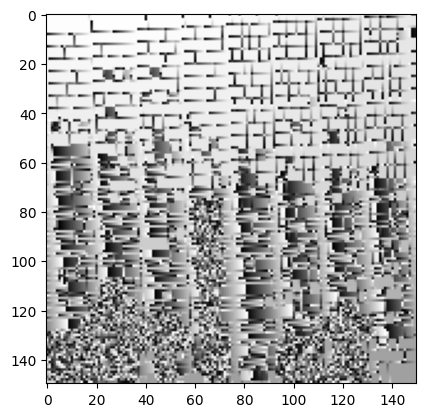

In [31]:
history = model.fit(
    train_flow, 
    steps_per_epoch=len(X_train) / 32, 
    epochs=100, 
    validation_data=val_flow, 
    validation_steps=1,
)


model.save('leak_and_nonleak_roy.h5')

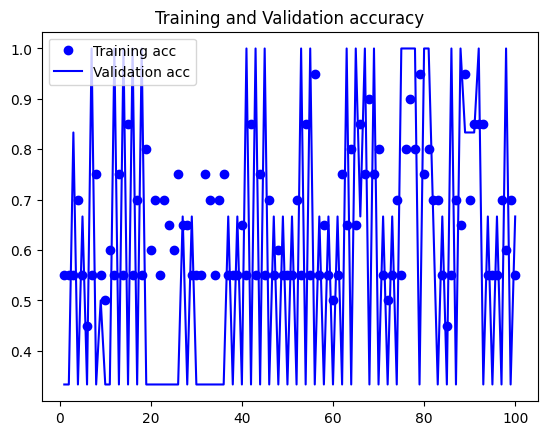

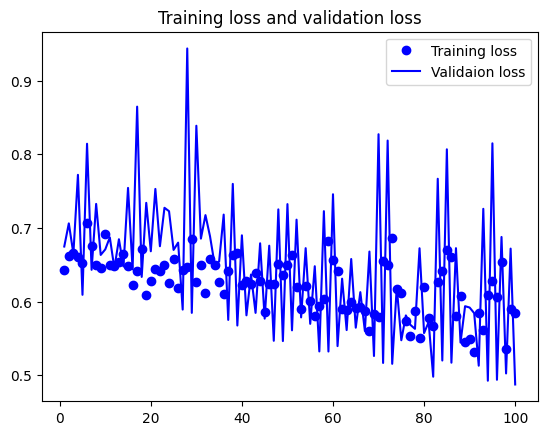

In [25]:
import matplotlib.pyplot as plt 

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and Validation accuracy') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validaion loss') 
plt.title('Training loss and validation loss') 
plt.legend() 

plt.show() 

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,       #
    width_shift_range=0.2,   # 
    height_shift_range=0.2,  # 
    shear_range=0.2,         # 
    zoom_range=0.2,          # 
    horizontal_flip=True,    # 
    fill_mode='nearest'      # 
)

# 
from keras.preprocessing import image 
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]
img_path = fnames[3]  # 
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)  # 
x = x.reshape((1, ) + x.shape)  # 

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i) 
    i += 1
    imgplot = plt.imshow(array_to_img(batch[0])) 
    if i % 4 == 0:
        break 
plt.show() 

In [ ]:
model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten()) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255) 
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary'
)

history = model.fit_generator(  
    
    train_generator, 
    steps_per_epoch=1, 
    epochs=30, 
    validation_data=validation_generator, 
    validation_steps=1
)

# Save
model.save('leak_and_nonleak_2.h5') 

In [ ]:
import matplotlib.pyplot as plt 

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and Validation accuracy') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validaion loss') 
plt.title('Training and validation loss') 
plt.legend() 

plt.show() 

In [ ]:
f1 = r'/Users/ianchen/Desktop/MethaneCNN/test/frame3018.jpg'  # nonleak
f2 = r'/Users/ianchen/Desktop/MethaneCNN/test/frame4414.jpg'  # leak

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img

img_path = f2
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)  # 
x = x.astype('float32') / 255
x = x.reshape((1, ) + x.shape)  # 

res = model.predict(x)  # 
leak_acc = 1 - res[0][0]
leak_acc

In [ ]:
import matplotlib.pyplot as plt 
from keras.preprocessing import image 
from keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img

model = load_model('./leak_and_nonleak_2.h5')
image_path = r'./test/frame4404.jpg'  # 
original_image = load_img(image_path)

img = load_img(image_path, target_size=(150, 150))
x = img_to_array(img) 
x = x.astype('float32') / 255 
x = x.reshape((1, ) + x.shape) 

res = model.predict(x)
res = res[0][0]
acc = 1- res

text = 'leak'
if res > 0.5:
    text = 'nonleak'
plt.imshow(original_image)
plt.axis("off")
plt.text(30, 40, text, fontdict=dict(fontsize=30, color='r',
            family='monospace',#
            weight='bold',#
            )#
)
plt.show()

In [ ]:
acc